# Recruitment Experiment

In developing lifelong learning algorithms, prior work has involved two main approaches: building and reallocating. Building involves adding new resources to support the arrival of new data, whereas reallocation involves compression of representations to make room for new ones. However, biologically, there is a spectrum between these two modes.

In order to examine whether current resources could be better leveraged, we test a range of approaches: **recruitment** of the best-performing existing trees, **building** new trees completely (the default approach used by lifelong classification forests), ignoring all prior trees (essentially an uncertainty forest), and a **hybrid** between building and recruitment.

This experiment examines the performance of these four approaches based on the available training sample size.

In [1]:
import numpy as np
import random
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import seaborn as sns

#import warnings
#warnings.filterwarnings(action='once')

import functions.recruitment_functions as fn

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


**Note:** This notebook tutorial uses functions stored externally within `functions/recruitment_functions.py` to simplify presentation of code. These functions are imported above, along with other libraries.

### CIFAR 10x10 Tasks

The classification problem that we examine in this tutorial makes use of the CIFAR 10x10 dataset. This dataset contains 


DESCRIBE CIFAR LATER HERE!!!

In [2]:
# import data 
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
data_x = np.concatenate([X_train, X_test])
data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

# maybe plot an example?

### The Experiment

Now that we have imported the CIFAR 10x10 dataset, we can prepare to run the experiment. The function for running the experiment, `experiment`, can be found within `functions/recruitment_functions.py`.

We first declare the hyperparameters to be used for the experiment, which are as follows:
- `ntrees`: describe
- `reps`: describe
- `estimation_set`: describe
- `num_points_per_task`: describe
- `num_points_per_forest`: describe
- `task_10_sample`: describe

In [9]:
############################
### Main hyperparameters ###
############################
ntrees = 50
#reps = 30
reps = 5
estimation_set = 0.63
num_points_per_task = 5000 # see sort_data
num_points_per_forest = 500 # maybe rename this 
task_10_sample = 10*np.array([10, 50, 100, 200, 350, 500])

To replicate the experiment found in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf), we use the hyperparameter values above.

Essentially, this trains a lifelong forest on the first nine CIFAR 10x10 tasks, where we have `50` trees (`ntrees`) and `500` samples (`num_points_per_forest`) for each set.

For the 10th task, we use training sample sizes ranging from `100` to `5000` (`task_10_sample`) and obtain generalization errors for each of the following approaches:
1. **Building (default for lifelong forests)**, which involves training `ntrees=50` new trees,
2. **Uncertainty forest**, which ignores all prior trees,
3. **Recruiting**, which selects the `ntrees=50` (out of all 450 existing trees) that perform best on the newly introduced 10th task, and
4. **Hybrid**, which both builds `ntrees/2=25` new trees and recruits the `ntrees/2=25` best-performing trees.

Let's call our `experiment` function and give it a run!

In [10]:
mean_acc_dict, std_acc_dict = fn.experiment(
    data_x, 
    data_y, 
    ntrees, 
    reps, 
    estimation_set, 
    num_points_per_task,
    num_points_per_forest, 
    task_10_sample
)

doing 100 samples for 0 th rep
doing 100 samples for 1 th rep
doing 100 samples for 2 th rep
doing 100 samples for 3 th rep
doing 100 samples for 4 th rep
0.905
0.9088
0.899
0.9006000000000001
doing 500 samples for 0 th rep
doing 500 samples for 1 th rep
doing 500 samples for 2 th rep
doing 500 samples for 3 th rep
doing 500 samples for 4 th rep
0.8944000000000001
0.9014
0.8874000000000001
0.8996000000000001
doing 1000 samples for 0 th rep
doing 1000 samples for 1 th rep
doing 1000 samples for 2 th rep
doing 1000 samples for 3 th rep
doing 1000 samples for 4 th rep
0.8836
0.8960000000000001
0.8778
0.9008
doing 2000 samples for 0 th rep
doing 2000 samples for 1 th rep
doing 2000 samples for 2 th rep
doing 2000 samples for 3 th rep
doing 2000 samples for 4 th rep
0.8932
0.9052
0.8846
0.9106
doing 3500 samples for 0 th rep
doing 3500 samples for 1 th rep
doing 3500 samples for 2 th rep
doing 3500 samples for 3 th rep
doing 3500 samples for 4 th rep
0.8666
0.8968
0.8712
0.8949999999999999


As you can see from the code above, our `experiment` function returns two dictionaries,`mean_acc_dict` and `std_acc_dict`, that respectively contain the means and standard deviations of the generalization errors for each approach (building, UF, recruiting, hybrid) over all repetitions. The dictionary keys correspond to each approach.

### Visualizing the Results

should see L2F outperform others except @ 5k training samples: "relative performance depends on available resources and sample size"

future work: "investigate optimal strtegies or determining how to optimally leverage existing resources given a new task"

0 hybrid
6
1 building
6
2 recruiting
6
3 UF
6


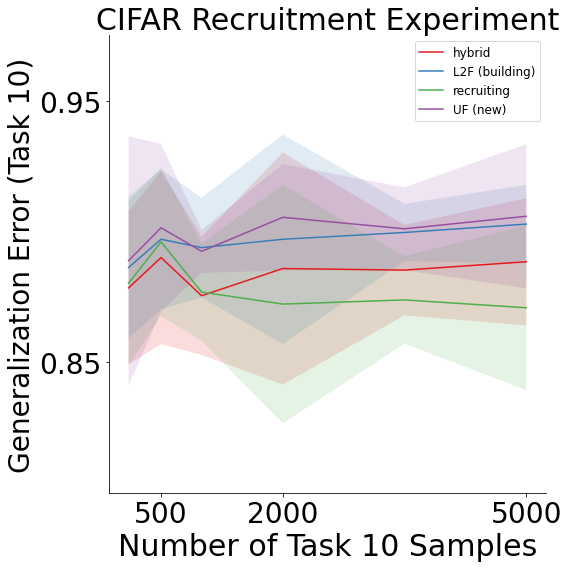

In [34]:
#ntrees = 50
#reps = 5
#estimation_set = 0.63
#num_points_per_task = 5000 
#num_points_per_forest = 500 
#task_10_sample = 10*np.array([10, 50, 100, 200, 350, 500])

fig, ax = plt.subplots(1,1, figsize=(8,8))

ns = task_10_sample

colors = sns.color_palette('Set1', n_colors=len(mean_acc_dict))
labels = ['hybrid', 'L2F (building)', 'recruiting', 'UF (new)']

for i, key in enumerate(mean_acc_dict):
    ax.plot(ns, mean_acc_dict[key], c=colors[i], label=labels[i])
    upper_bound = np.array(mean_acc_dict[key]) + 1.96*np.array(std_acc_dict[key])
    lower_bound = np.array(mean_acc_dict[key]) - 1.96*np.array(std_acc_dict[key])
    ax.fill_between(ns, 
                    upper_bound, 
                    lower_bound, 
                    where=upper_bound >= lower_bound,
                    facecolor=colors[i], 
                    alpha=0.15,
                    interpolate=False)

ax.set_title("CIFAR Recruitment Experiment",fontsize=30)
ax.set_ylabel('Generalization Error (Task 10)', fontsize=28)
ax.set_xlabel('Number of Task 10 Samples', fontsize=30)
ax.tick_params(labelsize=28)
ax.set_ylim(0.800, 0.975)
ax.set_xticks([500, 2000, 5000])
ax.set_yticks([0.85, 0.95]) # 0.35, 0.45, 0.55, 0.65, 0.75, 0.85

ax.legend(fontsize=12)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

plt.tight_layout()

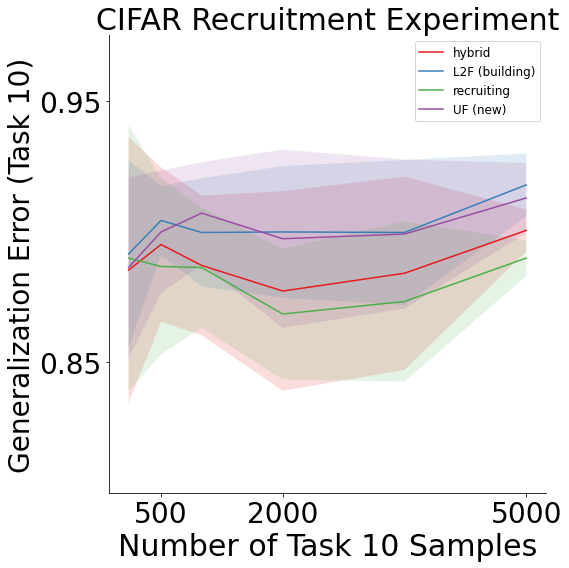

In [16]:
#ntrees = 50
#reps = 5
#estimation_set = 0.63
#num_points_per_task = 5000 
#num_points_per_forest = 500 
#task_10_sample = 10*np.array([10, 50, 100, 200, 350, 500])

fig, ax = plt.subplots(1,1, figsize=(8,8))

ns = task_10_sample

colors = sns.color_palette('Set1', n_colors=len(mean_acc_dict))
labels = ['hybrid', 'L2F (building)', 'recruiting', 'UF (new)']

for i, key in enumerate(mean_acc_dict):
    ax.plot(ns, mean_acc_dict[key], c=colors[i], label=labels[i])
    upper_bound = np.array(mean_acc_dict[key]) + 1.96*np.array(std_acc_dict[key])
    lower_bound = np.array(mean_acc_dict[key]) - 1.96*np.array(std_acc_dict[key])
    ax.fill_between(ns, 
                    upper_bound, 
                    lower_bound, 
                    where=upper_bound >= lower_bound,
                    facecolor=colors[i], 
                    alpha=0.15,
                    interpolate=False)

ax.set_title("CIFAR Recruitment Experiment",fontsize=30)
ax.set_ylabel('Generalization Error (Task 10)', fontsize=28)
ax.set_xlabel('Number of Task 10 Samples', fontsize=30)
ax.tick_params(labelsize=28)
ax.set_ylim(0.800, 0.975)
ax.set_xticks([500, 2000, 5000])
ax.set_yticks([0.85, 0.95]) # 0.35, 0.45, 0.55, 0.65, 0.75, 0.85

ax.legend(fontsize=12)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

plt.tight_layout()

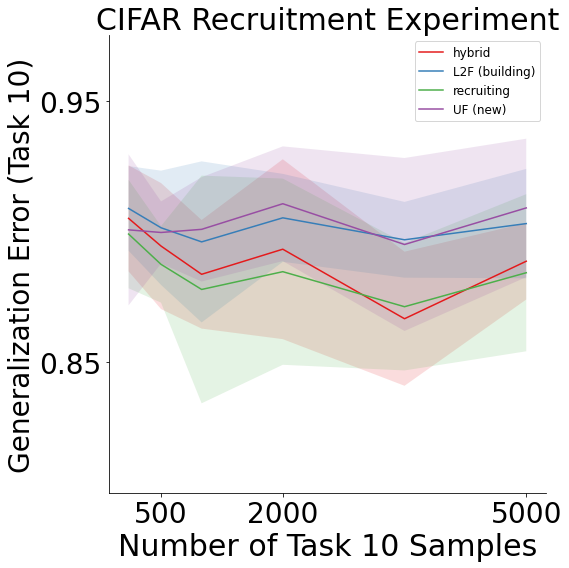

In [11]:
#ntrees = 50
#reps = 5
#estimation_set = 0.63
#num_points_per_task = 5000 
#num_points_per_forest = 500 
#task_10_sample = 10*np.array([10, 50, 100, 200, 350, 500])

fig, ax = plt.subplots(1,1, figsize=(8,8))

ns = task_10_sample

colors = sns.color_palette('Set1', n_colors=len(mean_acc_dict))
labels = ['hybrid', 'L2F (building)', 'recruiting', 'UF (new)']

for i, key in enumerate(mean_acc_dict):
    ax.plot(ns, mean_acc_dict[key], c=colors[i], label=labels[i])
    upper_bound = np.array(mean_acc_dict[key]) + 1.96*np.array(std_acc_dict[key])
    lower_bound = np.array(mean_acc_dict[key]) - 1.96*np.array(std_acc_dict[key])
    ax.fill_between(ns, 
                    upper_bound, 
                    lower_bound, 
                    where=upper_bound >= lower_bound,
                    facecolor=colors[i], 
                    alpha=0.15,
                    interpolate=False)

ax.set_title("CIFAR Recruitment Experiment",fontsize=30)
ax.set_ylabel('Generalization Error (Task 10)', fontsize=28)
ax.set_xlabel('Number of Task 10 Samples', fontsize=30)
ax.tick_params(labelsize=28)
ax.set_ylim(0.800, 0.975)
ax.set_xticks([500, 2000, 5000])
ax.set_yticks([0.85, 0.95]) # 0.35, 0.45, 0.55, 0.65, 0.75, 0.85

ax.legend(fontsize=12)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

plt.tight_layout()